In [1]:
# Import necessary library
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as scs
import joblib
import yaml
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

In [2]:
def load_parameter(parameter_direction):
    with open(parameter_direction,'r') as file:
        params = yaml.safe_load(file)
    
    return params

In [3]:
params = load_parameter("config/configuration_file_1.yaml")

In [4]:
params

{'data_direction': 'data/indeks-standar-pencemar-udara-di-spku-bulan-juni-sampai-desember-tahun-2021_1.xlsx',
 'datetime_columns': ['tanggal'],
 'int32_columns': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'label': 'categori',
 'label_categories': ['BAIK', 'TIDAK SEHAT'],
 'object_columns': ['stasiun', 'critical', 'categori'],
 'predictors': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'range_co': [-1, 100],
 'range_no2': [-1, 100],
 'range_o3': [-1, 160],
 'range_pm10': [-1, 800],
 'range_pm25': [-1, 400],
 'range_so2': [-1, 500],
 'range_stasiun': ['DKI1 (Bunderan HI)',
  'DKI2 (Kelapa Gading)',
  'DKI3 (Jagakarsa)',
  'DKI4 (Lubang Buaya)',
  'DKI5 (Kebon Jeruk) Jakarta Barat']}

# Exploratory Data Analysis

In [5]:
X_train = joblib.load("processed/X_train.pkl")
y_train = joblib.load("processed/y_train.pkl")

**1. Identify Missing Value**

In [6]:
# Store into variable
EDA_dataset_missing_value = pd.concat([X_train, y_train], axis = 1)

In [7]:
# Checking replaced value
for col in params['int32_columns']:
    print(len(EDA_dataset_missing_value[EDA_dataset_missing_value[col] == -1]))

15
13
56
2
15
1
0


In [8]:
# Replace value function
def replace_value(data, column, column_number, old_value, replace_value):
    
    """
    This function is to locate and replace value from a column. 
    
    :param data: <pandas dataframe> data contain sample
    :param column: <string> column name
    :param column_number: <string> single or multiple column
    :param old_value: <string/int/float> old value or current value
    :param replace_value: <string/int/float> value to replace old value
    :return data: <pandas dataframe> data contain sample
    """
    
    if str(column_number).lower() == "multiple":
        for col in column:
            data[col] = data[col].replace(old_value, replace_value)
    elif str(column_number).lower() == "single":
        data[column] = data[column].replace(old_value, replace_value)
        
    else: 
        "column_number is not correct"
        
    return data

In [9]:
# Replace value
EDA_dataset_missing_value = replace_value(data = EDA_dataset_missing_value, 
                                          column = params['int32_columns'],
                                          column_number = "multiple",
                                          old_value = -1, 
                                          replace_value = np.nan)

In [10]:
# Sanity check
EDA_dataset_missing_value.isna().sum()

tanggal      0
stasiun      0
pm10        15
pm25        13
so2         56
co           2
o3          15
no2          1
max          0
critical     0
categori     0
dtype: int64

**2. Identify skewness**

In [11]:
# Store into variable
EDA_dataset_skewness = EDA_dataset_missing_value

In [12]:
# Check skewness
EDA_dataset_skewness.skew(numeric_only = True)

pm10    0.676402
pm25    0.282551
so2    -0.076043
co      0.701355
o3      1.042900
no2     0.935780
max     0.543511
dtype: float64

- pm10 = skewness dari pm10 cukup signifikan sehingga menggunakan median
- pm25 = skewness dari pm25 tidak terlalu signifikan sehingga menggunakan mean
- so2 = skewness dari so2 tidak terlalu signifikan sehingga menggunakan mean
- co = skewness dari co cukup signifikan sehingga menggunakan median
- o3 = skewness dari o3 cukup signifikan sehingga menggunakan median
- no2 = skewness dari no2 cukup signifikan sehingga menggunakan median

In [13]:
# Split dataset
EDA_dataset_baik = EDA_dataset_skewness[EDA_dataset_skewness[params['label']] == params['label_categories'][0]]
EDA_dataset_tidak_baik = EDA_dataset_skewness[EDA_dataset_skewness[params['label']] != params['label_categories'][0]]

In [14]:
# Descriptive analysis
EDA_dataset_baik.describe()

,pm10,pm25,so2,co,o3,no2,max
count,40.000000,33.000000,37.000000,41.000000,40.000000,40.000000,41.000000
mean,28.150000,40.363636,27.729730,6.902439,24.450000,10.475000,42.487805
std,7.761014,6.990253,14.062655,4.352039,12.469347,5.193623,5.630817
min,15.000000,27.000000,4.000000,2.000000,8.000000,4.000000,30.000000
25%,23.000000,35.000000,15.000000,3.000000,14.000000,6.000000,38.000000
50%,28.000000,41.000000,31.000000,7.000000,18.000000,10.000000,44.000000
75%,31.250000,46.000000,36.000000,8.000000,37.000000,13.000000,47.000000
max,50.000000,50.000000,50.000000,28.000000,48.000000,29.000000,50.000000


In [15]:
# Descriptive analysis
EDA_dataset_tidak_baik.describe()

,pm10,pm25,so2,co,o3,no2,max
count,634.000000,643.000000,596.000000,646.000000,634.000000,648.000000,648.000000
mean,57.613565,85.129082,39.827181,11.662539,31.249211,22.270062,85.640432
std,12.549700,21.390534,11.579989,4.014013,12.550475,8.987690,20.792536
min,23.000000,26.000000,5.000000,3.000000,9.000000,6.000000,51.000000
25%,51.000000,71.000000,31.000000,9.000000,23.000000,15.000000,71.000000
50%,57.500000,83.000000,40.000000,11.000000,28.500000,21.000000,83.000000
75%,64.000000,98.000000,49.000000,14.000000,36.000000,27.000000,98.000000
max,179.000000,174.000000,82.000000,28.000000,77.000000,65.000000,179.000000


- pm10      : median dari kelas 0 dan 1 terpaut cukup jauh, maka akan menggunakan kelas
- pm25      : mean dari kelas 0 dan 1 terpaut cukup jauh, maka akan menggunakan kelas
- so2       : mean dari kelas 0 dan 1 tidak terpaut cukup jauh, maka tidak akan menggunakan kelas
- co        : median dari kelas 0 dan 1 tidak terpaut jauh, maka tidak akan menggunakan kelas
- o3        : median dari kelas 0 dan 1 tidak terpaut cukup jauh, maka tidak akan menggunakan kelas
- no2       : median dari kelas 0 dan 1 tidak terpaut cukup jauh, maka tidak akan menggunakan kelas

**3. Check outliers**

In [16]:
EDA_dataset_outliers = EDA_dataset_skewness

<AxesSubplot:>

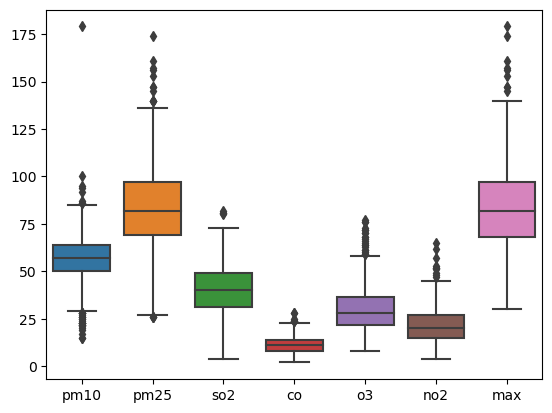

In [17]:
# Checking outliers using boxplot
sns.boxplot(data=EDA_dataset_outliers[params['int32_columns']])

**4. Identify correlation**

In [18]:
# Input-Output split function
def input_output_split(df, column):
    
    """
    This function is created to split input and output column
    :param df: <pandas dataframe> data contain sample
    :param columns: <string> column name
    :return X: <pandas dataframe> data contain input
    :return y: <pandas dataframe> data contain output
    """
    
    X = df.drop(column, axis = 1)
    y = df[column]
    
    return X,y

In [19]:
# Store into variable
EDA_dataset_correlation = pd.concat([X_train, y_train], axis = 1)

In [20]:
# Split input and output
EDA_X_train, EDA_y_train = input_output_split(df = EDA_dataset_correlation, column = params['label'])

# EDA_X_train_baik, EDA_y_train_baik = input_output_split(df = EDA_dataset_correlation[EDA_dataset_correlation[params['label']] == "BAIK"], column = params['label'])
# EDA_X_train_tidak_baik, EDA_y_train_tidak_baik = input_output_split(df = EDA_dataset_correlation[EDA_dataset_correlation[params['label']] != "BAIK"], column = params['label'])

# Sanity check
# print(f"{EDA_X_train.shape}, {EDA_y_train.shape} \n{EDA_X_train_baik.shape},  {EDA_y_train_baik.shape} \n{EDA_X_train_tidak_baik.shape}, {EDA_y_train_tidak_baik.shape}")

In [21]:
# Create Kendall's rank coefficient and p-value calculation function
def kendall_rank(input, output):
    
    """
    This function is created to calculate the level of significance between numeric type input data and object type output data 
    using kendall's rank
    
    :param input: <pandas dataframe> data contain input
    :param output: <pandas dataframe> data contain output  
    :return kendall_rank: <dictionary> collection of coefficient and p_value
    """
    
    # Create an empty dictionary to store the results
    kendall_rank = {}
    
    # Loop over each column in the numerical data DataFrame
    for col in input.columns:
        
        # Calculate Kendall's rank correlation coefficient    
        coefficient, p_value = kendalltau(input[col], output)
        
        # Store the results in the dictionary
        kendall_rank[col] = (coefficient, p_value)
    
    return kendall_rank

In [22]:
# Show Kendall's rank coefficient and p-value
kendall_rank(input = EDA_X_train[params['int32_columns']], output = EDA_y_train)

C:\Users\62821\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


{'pm10': (0.517006500771629, 3.85078834072556e-63),
 'pm25': (0.6261809717253971, 1.1651321446359456e-92),
 'so2': (0.15520803201682432, 5.08643843557653e-07),
 'co': (0.2090500630578317, 3.432774947417078e-11),
 'o3': (0.11112003220819085, 0.00031715865932951444),
 'no2': (0.2476701887225367, 1.2826565919262394e-15),
 'max': (0.6387247124208845, 2.5771840362539116e-96)}

No need to reducing feature since all of them have significant p-value but this will need to be re-check once the missing value has been handled.

**5. Check data proportion**

<AxesSubplot:xlabel='categori', ylabel='Count'>

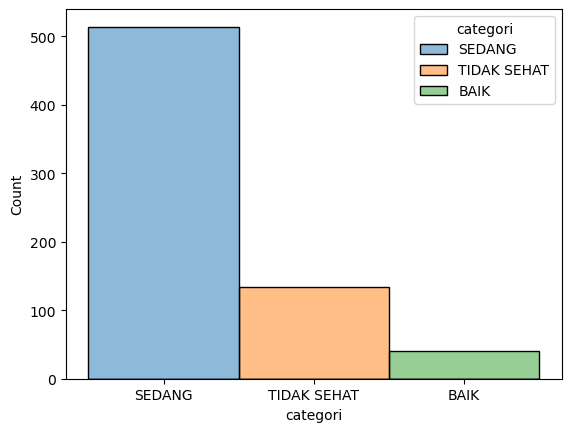

In [23]:
# Check data proportion
sns.histplot(data = pd.concat([X_train, y_train], axis = 1), x = params['label'], hue = params['label'])